# Ch 8 - Advanced Topics in Probability and Statistics

This notebook contains python code for generating figures in the Chapter 8 of the book _Mathematics in Biology_.

# Imports and Utilities

In [ ]:
import numpy as np
import random
from random import seed

from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import poisson, binom, t, norm, chi2, uniform, expon
from scipy import special

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('..\img')
    savedir.mkdir(parents=True, exist_ok=True)

datadir = Path('data')

In [2]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

### Random walks and diffusion


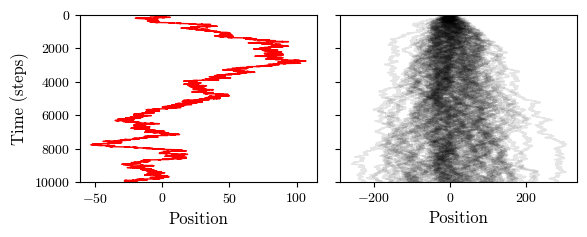

In [3]:
import random
random.seed(5) # choose random seed
n=10000 # number of steps per trajectory
p=0.5 # bias = prob of step=+1
m=100 # number of trajectories
pos=[np.cumsum(random.choices([1,-1],weights=[p,1-p],k=n)) for i in range(m)] # simulate m random walks of n steps
fig,ax=plt.subplots(1,2,figsize=(6,2.5))
t=np.arange(n) # time axis
plot(pos[0],t,fmts=['r-'],linewidth=1,
     ylabel='Time (steps)',xlabel='Position',ylim=[n,0], axes=ax[0]);
plot(pos,[t for i in range(m)],fmts=['k-']*len(pos),linewidth=1,alpha=0.1,
     # ylabel='Time (steps)',
     xlabel='Position',ylim=[n,0], axes=ax[1]);
ax[1].set_yticklabels([]);
# fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
if Save:
    fig.savefig(str(savedir / 'Random-walk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

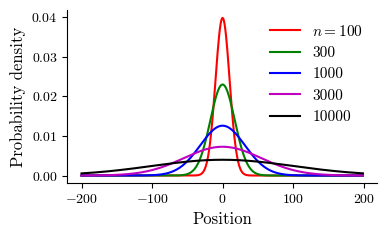

In [4]:
# Gaussian distribution parametric in time
p=0.5
x=np.arange(-200,200,1)
n=[100,300,1000,3000,10000]
y=[1/np.sqrt(2*np.pi*4*t*p*(1-p))*np.exp(-x*x/(2*4*t*p*(1-p))) for t in n]
fig, ax = plt.subplots(figsize=(4,2.5))
plot(x,y,fmts=['r-','g-','b-','m-','k-'], linewidth=1.5, 
     legend=['$n=${}'.format(n[0])]+n[1:],
     xlabel='Position',ylabel='Probability density', axes=ax);
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Random-walk-Gaussian.pdf'), dpi=600, format='pdf', bbox_inches='tight');

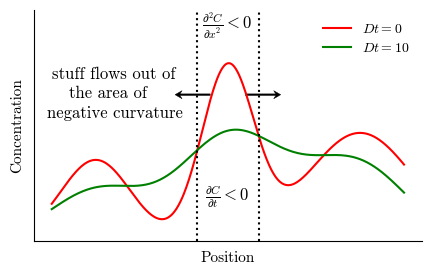

In [5]:
def Gauss(x,m,s):
    return np.exp(-(x-m)**2/(2*s**2))/(np.sqrt(2*np.pi)*s)
D=1 # Diffusion coefficient
dx=0.1 # resolution on position
x=np.arange(-20,20+dx,dx)
f=0.5*Gauss(x,-15,4)+0.8*Gauss(x,0,3)+1*Gauss(x,15,6)
t=10
s=np.sqrt(2*D*t)
h=Gauss(x,0,s)
g=np.convolve(f,h,mode='same')*dx # convolution integral
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x,f,'r-',label='Initial')
ax.plot(x,g,'g-',label='Final')
ax.set_xlabel('Position')
ax.set_ylabel('Concentration')

ax.set_ylim([0,1.3*max(f)])
ax.set_yticks([])
ax.set_xticks([])

ax.text(-2.9,0.13,r'$\frac{\partial^2 C}{\partial x^2}<0$',fontsize=12,color='k')
ax.text(-2.6,0.025,r'$\frac{\partial C}{\partial t}<0$',fontsize=12,color='k')
ax.text(-20,0.1,'stuff flows out of',fontsize=12,color='k')
ax.text(-18,0.088,'the area of',fontsize=12,color='k')
ax.text(-20.5,0.076,'negative curvature',fontsize=12,color='k')
ax.plot([-3.5,-3.5],[0,0.16],'k',linestyle='dotted')
ax.plot([3.5,3.5],[0,0.16],'k',linestyle='dotted')
ax.arrow(2,0.09,4,0,width=0.001,length_includes_head=True,linewidth=0.3,head_width=0.005,head_length=0.8,
                overhang=0.3,color='k')
ax.arrow(-2,0.09,-4,0,width=0.001,length_includes_head=True,linewidth=0.3,head_width=0.005,head_length=0.8,
                overhang=0.3,color='k')
ax.legend(['$Dt=0$','$Dt=10$'], fontsize = 10, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if Save:
    fig.savefig(str(savedir / 'diff-eqn-qual-2.pdf'), dpi=600, format='pdf', bbox_inches='tight');

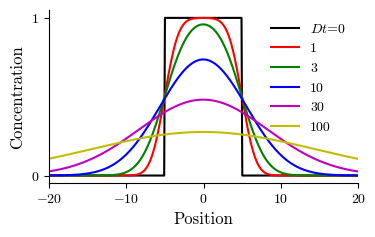

In [6]:
def Green(x,Dt):
    return np.exp(-x**2/(4*Dt))/np.sqrt(4*np.pi*Dt)

dx=0.1 # resolution on position
DtList=[1,3,10,30,100] # values of Dt
x=np.arange(-50,50+dx,dx) # x-axis
f=np.where(np.logical_and(x>-5,x<5),1,0) # initial condition
g=[np.convolve(f,Green(x,Dt),mode='same')*dx for Dt in DtList] # convolution integral
fig, ax = plt.subplots(figsize=(4,2.5))
plot(x,[f]+g,fmts=['k-','r-','g-','b-','m-','y-'],linewidth=1.5, xlabel='Position',ylabel='Concentration',
    # legend=['$Dt$=0']+DtList, 
    xlim=[-20,20],
    axes=ax);
# Move the legend to the right
ax.legend(['$Dt$=0']+DtList, loc='upper right', bbox_to_anchor=(1.0, 1), frameon=False, fontsize=10)
ax.set_yticks([0,1])

# fig.tight_layout()
# ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'diff-hat.pdf'), dpi=600, format='pdf', bbox_inches='tight');

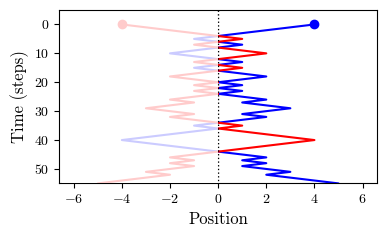

In [7]:
random.seed(5) # choose random seed
n=100 # number of steps per trajectory
p=0.5 # bias = prob of step=+1
x=5+np.cumsum(random.choices([1,-1],weights=[p,1-p],k=n)) # simulate one random walk
y=np.arange(n)
fig, ax = plt.subplots(figsize=(4,2.5))
plot([x,-x],[y,y],fmts=['b-','r-'],linewidth=1.5, ylabel='Time (steps)',xlabel='Position', axes=ax)
plot([0,0],[-5,105],fmts=['k:'],linewidth=1,axes=ax);
plot([x[0]],[y[0]],fmts=['bo'],markersize=6,axes=ax);
plot([-x[0]],[y[0]],fmts=['ro'],markersize=6,ylim=[55,-5],axes=ax);
ax.add_patch(Rectangle((-6.5,-3),6.5,106,facecolor="white",zorder=3,alpha=0.8));
# fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'mirror-sources.pdf'), dpi=600, format='pdf', bbox_inches='tight');

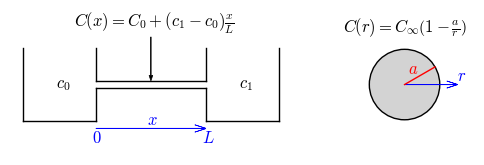

In [8]:
from matplotlib.patches import Rectangle, Circle

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(6, 2), gridspec_kw={'width_ratios': [2, 1]})

ax.plot([0,0],[0,2],'k',linewidth=1)
ax.plot([0,2],[0,0],'k',linewidth=1)
ax.plot([2,2],[0,0.9],'k',linewidth=1)
ax.plot([2,2],[1.1,2],'k',linewidth=1)

ax.plot([5,5],[0,0.9],'k',linewidth=1)
ax.plot([5,5],[1.1,2],'k',linewidth=1)
ax.plot([5,7],[0,0],'k',linewidth=1)
ax.plot([7,7],[0,2],'k',linewidth=1)

ax.plot([2,5],[0.9,0.9],'k',linewidth=1)
ax.plot([2,5],[1.1,1.1],'k',linewidth=1)

ax.arrow(2,-0.2,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='b',linewidth=0.5)
ax.text(3.4,-0.1,r'$x$',fontsize=12,color='b')
ax.text(1.9,-0.6,r'$0$',fontsize=12,color='b')
ax.text(4.9,-0.6,r'$L$',fontsize=12,color='b')
ax.text(1.4,2.6,r'$C(x)=C_0+(c_1-c_0) \frac{x}{L}$',fontsize=12,color='k')
ax.text(0.9,0.9,r'$c_0$',fontsize=12,color='k')
ax.text(5.9,0.9,r'$c_1$',fontsize=12,color='k')
ax.arrow(3.5,2.3,0,-1.2,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)

ax.axis("off");

ax1.add_patch(Circle((0, 0),1,edgecolor='k',facecolor='lightgray'))

ax1.arrow(0,0,1.5,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='b',linewidth=0.5)
ax1.plot([0,np.cos(np.pi/6)],[0,np.sin(np.pi/6)],'r-',linewidth=1)
ax1.text(0.1,0.3,r'$a$',fontsize=12,color='r')
ax1.text(1.5,0.1,r'$r$',fontsize=12,color='b')
ax1.text(0,1.3,r'$C(r)=C_\infty\left(1-\frac{a}{r}\right)$',fontsize=12,color='k',ha='center',va='bottom')
ax1.axis("off");

ax1.set_xlim([-2,2])
ax1.set_ylim([-2,2])

ax.set_aspect('equal')
ax1.set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'DiffExamples.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Random time series

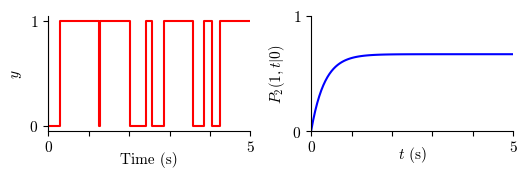

In [9]:
fig,axes=plt.subplots(1,2,figsize=(6,1.5))
np.random.seed(2)
n=10 # number of switches to 1 and back to 0
a01=2
a10=1
t01=np.random.exponential(1/a01,10)
t10=np.random.exponential(1/a10,10)
t=[u for v in zip(t01,t10) for u in v] # time of the switches
t=np.cumsum(t)
x=[0,0]+[u for u in t for _ in (0, 1)]
y=[1,0]+[0,1,1,0]*n

ax=axes[0]
ax.plot(x, y, 'r-', linewidth=1.5)
ax.set_xlabel(r'Time (s)')
ax.set_ylabel(r'$y$')
ax.yaxis.set_label_coords(-0.12, 0.5)  # Adjust the position of the ylabel
ax.xaxis.set_label_coords(0.5, -0.18)  # Adjust the position of the xlabel
ax.set_xlim([0,5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['0','','','','','5']);
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x=np.linspace(0,5,100)
y=a01/(a01+a10)*(1-np.exp(-(a01+a10)*x))

ax=axes[1]
ax.plot(x, y, 'b-', linewidth=1.5)
ax.set_xlabel(r'$t$ (s)')
ax.xaxis.set_label_coords(0.5, -0.12)  # Adjust the position of the xlabel
ax.set_ylabel(r'${P_2} \left(1,t \vert 0 \right)$')
ax.yaxis.set_label_coords(-0.12, 0.5)  # Adjust the position of the xlabel
ax.set_ylim([0,1])
ax.set_xlim([0,5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['0','','','','','5'])
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.subplots_adjust(wspace=0.3)

if Save:
    fig.savefig(str(savedir / 'random_telegraph.pdf'), dpi=600, format='pdf', bbox_inches='tight');

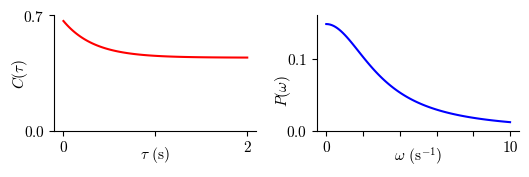

In [10]:
fig,axes=plt.subplots(1,2,figsize=(6,1.5))

np.random.seed(2)
a01=2
a10=1
a=a01+a10
b=a01/a
ti=np.linspace(0,2,100) # time
C=b*(b+(1-b)*np.exp(-a*ti))
om=np.linspace(0,10,100) # omega
P=2*b*(1-b)*a/(a**2+om**2)

ax=axes[0]
ax.plot(ti,C,'r-',linewidth=1.5)
ax.set_xlabel(r'$\tau$ (s)')
ax.xaxis.set_label_coords(0.5, -0.12)  # Adjust the position of the xlabel
ax.set_ylabel(r'$C(\tau)$')
ax.yaxis.set_label_coords(-0.12, 0.5)  # Adjust the position of the ylabel
ax.set_xticks([0,1,2])
ax.set_xticklabels(['0','','2'])
ax.set_yticks([0,0.7])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax=axes[1]
ax.plot(om,P,'b-',linewidth=1.5)
ax.set_xlabel(r'$\omega$ (s$^{-1}$)')
ax.xaxis.set_label_coords(0.5, -0.12)  # Adjust the position of the xlabel
ax.set_ylabel(r'$P(\omega)$')
ax.yaxis.set_label_coords(-0.12, 0.35)  # Adjust the position of the ylabel
ax.set_ylim([0,0.16])
ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels(['0','','','','','10'])
ax.set_yticks([0,0.1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.subplots_adjust(wspace=0.3)

if Save:
    fig.savefig(str(savedir / 'rand-tele-corr.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Hidden Markov models

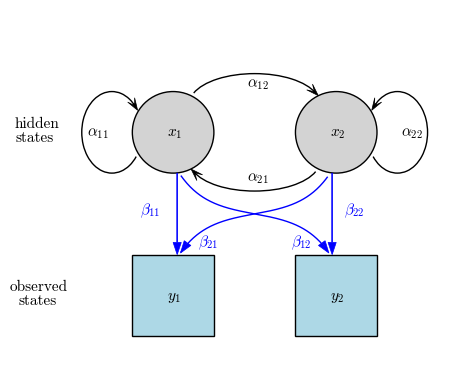

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib.patches import Rectangle, Circle, Arc
import math

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.text(-1.44,2.55,r'hidden',color='k')
ax.text(-1.43,2.38,r'states',color='k')
ax.text(-1.5,0.55,r'observed',color='k')
ax.text(-1.4,0.38,r'states',color='k')
ax.add_patch(Circle((0.5, 2.5),0.5,edgecolor='k',facecolor='lightgray'))
ax.add_patch(Circle((2.5, 2.5),0.5,edgecolor='k',facecolor='lightgray'))
ax.text(0.42,2.45,r'$x_1$',color='k')
ax.text(2.42,2.45,r'$x_2$',color='k')
ax.add_patch(Rectangle((0, 0), 1, 1,edgecolor='k',facecolor='lightblue'))
ax.add_patch(Rectangle((2, 0), 1, 1,edgecolor='k',facecolor='lightblue'))
ax.text(0.42,0.45,r'$y_1$',color='k')
ax.text(2.42,0.45,r'$y_2$',color='k')
ax.arrow(0.55,2,0,-1,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='b',linewidth=0.5)
ax.arrow(2.45,2,0,-1,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='b',linewidth=0.5)
ax.text(0.1,1.5,r'$\beta_{11}$',color='b')
ax.text(2.6,1.5,r'$\beta_{22}$',color='b')

ax.add_patch(Arc((-0.25,2.5), 2*0.37, 1, angle=0.0, theta1=45, theta2=315.0,edgecolor='k'))
ax.add_patch(Arc((3.25,2.5), 2*0.37, 1, angle=0.0, theta1=225, theta2=135.0,edgecolor='k'))
ax.arrow(0.015,2.85,0.05,-0.08,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0.5,color='k',linewidth=0.5)
ax.arrow(3-0.015,2.85,-0.05,-0.08,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0.5,color='k',linewidth=0.5)
ax.add_patch(Arc((1.5,2.15), 1.6, 2*0.37,  angle=0.0, theta1=190, theta2=350,edgecolor='k'))
ax.arrow(0.77,2,-0.05,0.05,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0.5,color='k',linewidth=0.5)
ax.add_patch(Arc((1.5,2.85), 1.6, 2*0.37,  angle=0.0, theta1=10, theta2=170,edgecolor='k'))
ax.arrow(2.23,3,0.05,-0.05,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0.5,color='k',linewidth=0.5)

ax.text(1.4,3.05,r'$\alpha_{12}$',color='k')
ax.text(1.4,1.9,r'$\alpha_{21}$',color='k')
ax.text(-0.55,2.45,r'$\alpha_{11}$',color='k')
ax.text(3.3,2.45,r'$\alpha_{22}$',color='k')

x=np.arange(0.6,2.4,0.01)
y=np.sinh(3*(x-1.5))/16+1.5
y2=-np.sinh(3*(x-1.5))/16+1.5

ax.plot(x,y,'b',linewidth=1)
ax.arrow(0.64,1.09,-0.05,-0.07,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='b',linewidth=0.5)

ax.plot(x,y2,'b',linewidth=1)
ax.arrow(2.36,1.09,0.05,-0.07,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='b',linewidth=0.5)

ax.text(1.95,1.1,r'$\beta_{12}$',color='b')
ax.text(0.8,1.1,r'$\beta_{21}$',color='b')

ax.set_xlim([-1.5,4])
ax.set_ylim([-0.5,4])
ax.set_aspect('equal')
ax.axis("off")
fig.tight_layout()

fig1=plt.gcf()
plt.show()
plt.draw()

if Save:
    fig1.savefig(str(savedir / 'HMMschema.pdf'), dpi=600, format='pdf', bbox_inches='tight');

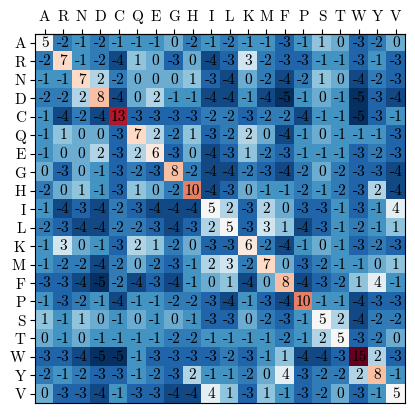

In [12]:
from scipy.stats import zscore
from sklearn.decomposition import PCA

X=np.load(str(datadir / "blosum50.npz"))

fig,a1=plt.subplots(1,1)
a1.imshow(X['blo_mat'][0:20,0:20], cmap="RdBu_r");

secax = a1.secondary_xaxis('top');
secax.set_xticks(np.arange(len(X['aa_names'])-3));
a1.set_yticks(np.arange(len(X['aa_names'])-3));
secax.set_xticklabels(X['aa_names'][0:20]);
a1.set_yticklabels(X['aa_names'][0:20]);
a1.axes.get_xaxis().set_visible(False);
for i in range(len(X['aa_names'])-3):
    for j in range(len(X['aa_names'])-3):
        texts=a1.text(i, j, int(X['blo_mat'][i,j]),ha="center", va="center", color="k");
        
if Save:
    fig.savefig(str(savedir / 'BLOSUM-50.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Dimensionality reduction

#### Principal component analysis

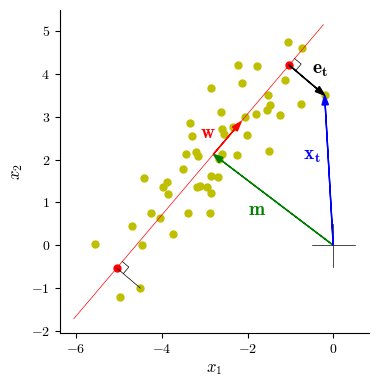

In [32]:
def Cov(X):
    '''
    Computes sample covariance of data in X
    X[i] = i-th data point
    '''
    m=X.shape[0] # number of data points
    n=X.shape[1] # dimensionality of the data
    M=np.mean(X,axis=0) # mean of the data
    C=np.zeros((n,n))
    for i in range(m):
        C+=np.outer(X[i]-M,X[i]-M)
    C/=m
    return C

T=50 # number of data points
rs=0 # random seed
np.random.seed(rs)
xm=-3 # x mean
ym=2 # ymean
x=xm+np.random.randn(T)
y=(x-xm)*1+ym+0.8*np.random.randn(T) # slope of 1
X=np.array([[x,y] for x,y in zip(x,y)]) # data matrix
X[-1]=[-0.2,3.5] # specify the last data point for convenient annotation
X[-2]=[-4.5,-1] # another data point
M=np.mean(X,axis=0) # mean of the data cloud
C=Cov(X) # covariance matrix
w,v=np.linalg.eigh(C) # eigenvalues & vectors in ascending order
P=v[-1] # first PC
if P[0]<0: # make it point up and to the right
    P*=-1
fig, ax = plt.subplots(figsize=(4,4))
plot(X[:,0],X[:,1],equal=True,fmts=['yo'],
    xlim=[-6,1],ylim=[-1,6],axes=ax,
    xlabel=r'$x_1$',ylabel=r'$x_2$',
);
ax.arrow(0,0,M[0],M[1],head_width=0.15,color='g',length_includes_head=True,zorder=10);
ax.arrow(M[0],M[1],P[0],P[1],head_width=0.15,color='r',length_includes_head=True,zorder=10);
xr=np.array([np.min(x)-0.5,np.max(x)+0.5]) # x range for the PC line
yr=M[1]+(xr-M[0])*P[1]/P[0] # y for the PC line
plot(xr,yr,fmts=['r-'],linewidth=0.5,axes=ax)
plot([-.5,.5],[0,0],fmts=['k-'],linewidth=0.5,axes=ax)
plot([0,0],[-.5,.5],fmts=['k-'],linewidth=0.5,axes=ax)

S=X[-1] # sample point for annotation
ax.arrow(0,0,S[0],S[1],head_width=0.15,color='b',length_includes_head=True,zorder=10);
A=M+(P@(S-M))*P # approximation to the sample point on the PC line
E=S-A # error for that sample
plot([A[0]],[A[1]],fmts=['ro'],markersize=5,axes=ax)
ax.arrow(A[0],A[1],E[0],E[1],head_width=0.15,color='k',length_includes_head=True,zorder=10);
r=np.array([A+0.2*P,A+0.2*P+0.2*E/np.sqrt(np.dot(E,E)),A+0.2*E/np.sqrt(np.dot(E,E))]) # right angle symbol
plot(r[:,0],r[:,1],fmts=['k-'],linewidth=0.5,axes=ax);

S=X[-2] # sample point for annotation
# ax.arrow(0,0,S[0],S[1],head_width=0.15,color='b',length_includes_head=True,zorder=10);
A=M+(P@(S-M))*P # approximation to the sample point on the PC line
E=S-A # error for that sample
plot([A[0]],[A[1]],fmts=['ro'],markersize=5,axes=ax)
plot([A[0],S[0]],[A[1],S[1]],fmts=['k-'],linewidth=0.5,axes=ax)
r=np.array([A+0.2*P,A+0.2*P+0.2*E/np.sqrt(np.dot(E,E)),A+0.2*E/np.sqrt(np.dot(E,E))]) # right angle symbol
plot(r[:,0],r[:,1],fmts=['k-'],linewidth=0.5,axes=ax);

ax.text(-2,0.7,r'$\bf{m}$',fontsize=14,color='green');
ax.text(-3.1,2.5,r'$\bf{w}$',fontsize=14,color='red');
ax.text(-0.7,2,r'$\bf{x}_t$',fontsize=14,color='blue');
ax.text(-0.5,4,r'$\bf{e}_t$',fontsize=14,color='black');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'pca-cloud.pdf'), dpi=600, format='pdf', bbox_inches='tight');

In [14]:
# import math
# from random import seed
# from random import random
# from random import randint
# from scipy.linalg import lstsq

# seed(9)
# N=50
# data=np.empty((2,N))
# for i in range(N):
#     xnew=random()*10
#     data[0,i]=xnew
#     ynew=xnew - 50 + random()*6
#     data[1,i]=ynew

# fig, ax = plt.subplots(figsize=(5,3))

# data[0,:]=data[0,:]-np.mean(data[0,:])
# data[1,:]=data[1,:]-np.mean(data[1,:])

# ax.scatter(data[0,:],data[1,:],5,'k');
# x=np.asarray(data[0,:])
# y=np.asarray(data[1,:])
# M = x[:, np.newaxis]**[0, 1]
# p, res, rnk, s = lstsq(M, y)
# xx = np.linspace(np.min(data[0,:]), np.max(data[0,:]), 101)
# yy = p[0] + p[1]*xx**1

# ax.plot(xx, yy, 'r', label='Linear regression');

# from sklearn.decomposition import PCA
# pca=PCA(n_components=1)
# pca.fit(np.transpose(data))
# grad=pca.components_[0,1]/pca.components_[0,0]
# yy2 = grad*xx**1

# ax.plot(xx, yy2, 'g', label='PC 1');
# ax.legend(framealpha=1);
# ax.grid(alpha=0.25);
# fig.tight_layout()
# fig.savefig(str(savedir / 'dimred-lin-reg.pdf'), dpi=600, format='pdf', bbox_inches='tight');

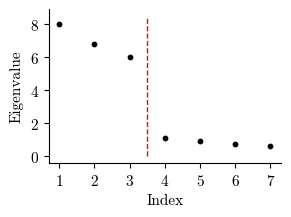

In [15]:
fig, ax=plt.subplots(figsize=(3,2))
ax.scatter(np.asarray(range(1,8)),[8, 6.8, 6, 1.1, 0.9, 0.7, 0.6], 10, color='k');
ax.set_ylabel("Eigenvalue");
ax.set_xlabel("Index");
ax.plot([3.5, 3.5], [0, 8.5], color='r', linestyle='--', linewidth=1);
ax.set_xticks([1,2,3,4,5,6,7]);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'dimred-sample-scree.pdf'), dpi=600, format='pdf', bbox_inches='tight');

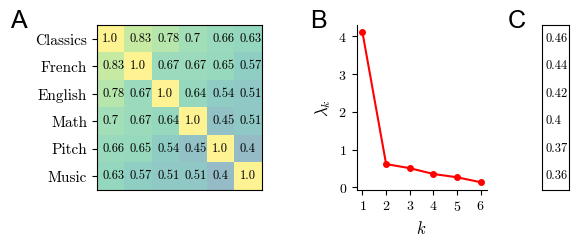

In [16]:
# Classics French English Math Pitch Music
C=np.array(
[[1.00,0.83,0.78,0.70,0.66,0.63],
[0.83,1.00,0.67,0.67,0.65,0.57],
[0.78,0.67,1.00,0.64,0.54,0.51],
[0.70,0.67,0.64,1.00,0.45,0.51],
[0.66,0.65,0.54,0.45,1.00,0.40],
[0.63,0.57,0.51,0.51,0.40,1.00]]
)

w,v=np.linalg.eigh(C) # eigenvalues & vectors in ascending order
u=v[:,-1] # top eigenvector
if u[0]<0:
    u=-u
u=np.reshape(u,(-1,1)) # turn into 6x1 array for display

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax=plt.subplots(1,3,figsize=(6,2.5),width_ratios=[3,1.5,0.5])

# divider=make_axes_locatable(ax[0])
# cax=divider.append_axes('right', size='5%', pad=0.05)
im=ax[0].imshow(C,vmin=0,vmax=1,alpha=0.5);
labels=['Classics','French','English','Math','Pitch','Music']
ax[0].set_yticks(np.arange(6));
ax[0].set_yticklabels(labels);
ax[0].set_xticks([]);
# fig.colorbar(im,cax=cax,orientation='vertical')
for i in range(6):
    for j in range(6):
        ax[0].text(i-0.3,j+0.1,C[i,j],fontsize=9)
        
plot(np.arange(1,7),w[-1::-1],fmts=['ro-'], linewidth=1.5, markersize=4, 
     xlabel=r'$k$',ylabel=r'$\lambda_k$',axes=ax[1]);
ax[1].set_xticks(np.arange(1,7))
ax[1].set_yticks(np.arange(5))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[2].imshow(u,vmin=0,vmax=1,alpha=0.0)
for i in range(6):
    ax[2].text(-0.35,i+0.1,np.round(u[i,0],2), fontsize=9)
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.text(0.02,0.9,'A',fontsize=18,font='Arial')
fig.text(0.52,0.9,'B',fontsize=18,font='Arial')
fig.text(0.85,0.9,'C',fontsize=18,font='Arial')
# fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Spearman-PCA.pdf'), dpi=600, format='pdf', bbox_inches='tight');

In [17]:
# import scipy.linalg as la

# cov_matrix=np.asarray([[1,0.83,0.78,0.7,0.66,0.63],[0.83,1,0.67,0.67,0.65,0.57],[0.78,0.67,1,0.64,0.54,0.51],[0.7,0.67,0.64,1,0.45,0.51],[0.66,0.65,0.54,0.45,1,0.40],[0.63,0.57,0.51,0.51,0.40,1]])

# eigvals, eigvecs = la.eig(cov_matrix)
# eigvals=eigvals.real
# eigvals2=np.sort(eigvals)
# eigvals2=eigvals2[::-1]

# PC1=np.squeeze(eigvecs[eigvals==eigvals2[0]])
# PC1=PC1/(np.linalg.norm(PC1))

# fig, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [4,4,1]}, figsize=(8,4))

# im=a0.imshow(cov_matrix, aspect="auto", vmin=0, vmax=1, cmap="RdBu_r")
# a0.set_xticks(np.arange(6))
# a0.set_yticks(np.arange(6))
# a0.set_yticklabels(('Classics', 'French', 'English', 'Math', 'Pitch', 'Music'))
# a0.set_xticklabels(('Classics', 'French', 'English', 'Math', 'Pitch', 'Music'))
# plt.colorbar(im,ax=a0)
# plt.setp(a0.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# a1.scatter(np.asarray(range(1,7,1)), eigvals2/sum(eigvals2), color='k')
# a1.set_ylabel("Fractional variance explained")
# a1.set_xlabel("Eigenvalue index")
# a2.imshow(np.transpose([PC1,]*10), aspect="auto", vmin=-1, vmax=1, cmap="RdBu_r")
# for i in range(6):
#     text = a2.text(5, i, round(PC1[i],2),
#                    ha="center", va="center", color="k")
# a2.axis('off')
# fig.tight_layout()
# fig.savefig(str(savedir / 'dimred-spearman-corr.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### Example: dimensionality reduction of neuronal population activity

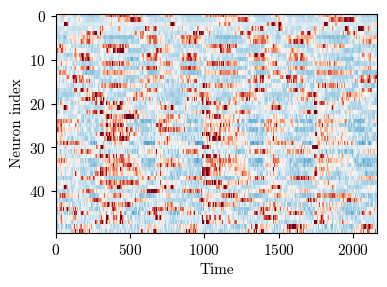

In [18]:
from scipy.stats import zscore

all_traces=np.load(str(datadir / "neuronal_population_traces.npy"))

fig, ax=plt.subplots(figsize=(4,3))
ax.imshow(zscore(all_traces, 1), aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none")
ax.set_ylabel("Neuron index")
ax.set_xlabel("Time")
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'dimred-neur-activity.pdf'), dpi=600, format='pdf', bbox_inches='tight');

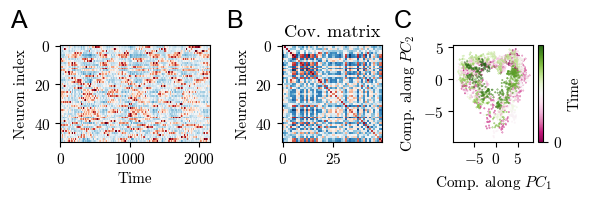

In [19]:

from scipy.sparse.linalg import eigs

all_traces=np.load(str(datadir / "neuronal_population_traces.npy"))
all_traces=zscore(all_traces, 1)

for i in range(all_traces.shape[1]):
    all_traces[:,i]=all_traces[:,i]-np.mean(all_traces[:,i],0)

fig, ax= plt.subplots(1,3,figsize=(6,2),width_ratios=[3,2,2])
ax[0].imshow(all_traces, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none")
ax[0].set_ylabel("Neuron index")
ax[0].set_xlabel("Time")

C=np.matmul(all_traces,np.transpose(all_traces))

ax[1].imshow(C, aspect="auto", cmap="RdBu_r", interpolation="none")
ax[1].set_title("Cov. matrix")
ax[1].set_ylabel("Neuron index")

w,v=eigs(C,k=10,which='LR')

Loadings=np.zeros([5,all_traces.shape[1]])

for i in range(all_traces.shape[1]):
    Loadings[0,i]=np.dot(all_traces[:,i],v[:,0].real)
    Loadings[1,i]=np.dot(all_traces[:,i],v[:,1].real)
    Loadings[2,i]=np.dot(all_traces[:,i],v[:,2].real)
    Loadings[3,i]=np.dot(all_traces[:,i],v[:,3].real)
    Loadings[4,i]=np.dot(all_traces[:,i],v[:,4].real)
    
R=np.linspace(0,1,all_traces.shape[1])
R2=np.linspace(0,1,int(all_traces.shape[1]/2))

Rcolor=np.zeros([all_traces.shape[1],3])
for i in range(all_traces.shape[1]):
    if i<all_traces.shape[1]/2:
        Rcolor[i,0]=0
        Rcolor[i,1]=R2[-i]
        Rcolor[i,2]=0
    else:
        Rcolor[i,0]=R2[i-int(all_traces.shape[1]/2)]
        Rcolor[i,1]=0
        Rcolor[i,2]=R2[i-int(all_traces.shape[1]/2)]
        
im2=ax[2].scatter(Loadings[0,:],Loadings[1,:],s=0.1,c=R,cmap="PiYG")
ax[2].set_xlabel("Comp. along $PC_1$")
ax[2].set_ylabel("Comp. along $PC_2$")

fig.colorbar(im2,ax=ax[2],ticks=range(1),label='Time')


fig.text(0.02,0.9,'A',fontsize=18,font='Arial')
fig.text(0.38,0.9,'B',fontsize=18,font='Arial')
fig.text(0.66,0.9,'C',fontsize=18,font='Arial')

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'dimred-neur-activity-new-old.pdf'), dpi=600, format='pdf', bbox_inches='tight');



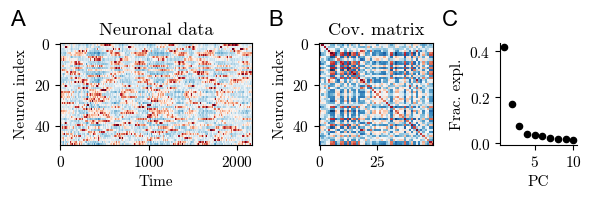

In [20]:

from scipy.sparse.linalg import eigs

all_traces=np.load(str(datadir / "neuronal_population_traces.npy"))
all_traces=zscore(all_traces, 1)

for i in range(all_traces.shape[1]):
    all_traces[:,i]=all_traces[:,i]-np.mean(all_traces[:,i],0)

fig, ax= plt.subplots(1,3,figsize=(6,2),width_ratios=[3,1.8,1.2])
ax[0].imshow(all_traces, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none")
ax[0].set_ylabel("Neuron index")
ax[0].set_xlabel("Time")
ax[0].set_title("Neuronal data")

C=np.matmul(all_traces,np.transpose(all_traces))

ax[1].imshow(C, aspect="auto", cmap="RdBu_r", interpolation="none")
ax[1].set_title("Cov. matrix")
ax[1].set_ylabel("Neuron index")

t_variance=0
for i in range(all_traces.shape[1]):
    t_variance=t_variance+np.dot(all_traces[:,i],all_traces[:,i])

ax[2].scatter(list(range(1, len(w)+1)), w.real/t_variance, 20, color='k')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('PC')
ax[2].set_ylabel('Frac. expl.')


fig.text(0.02,0.9,'A',fontsize=16,font='Arial')
fig.text(0.45,0.9,'B',fontsize=16,font='Arial')
fig.text(0.74,0.9,'C',fontsize=16,font='Arial')


fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'dimred-neur-activity-new.pdf'), dpi=600, format='pdf', bbox_inches='tight');



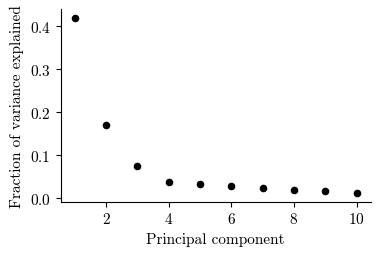

In [21]:
fig, ax = plt.subplots(figsize=(4,2.5))


t_variance=0
for i in range(all_traces.shape[1]):
    t_variance=t_variance+np.dot(all_traces[:,i],all_traces[:,i])

ax.scatter(list(range(1, len(w)+1)), w.real/t_variance, 20, color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Principal component')
plt.ylabel('Fraction of variance explained')
if Save:
    fig.savefig(str(savedir / 'dimred-neur-frac-var.pdf'), dpi=600, format='pdf', bbox_inches='tight');

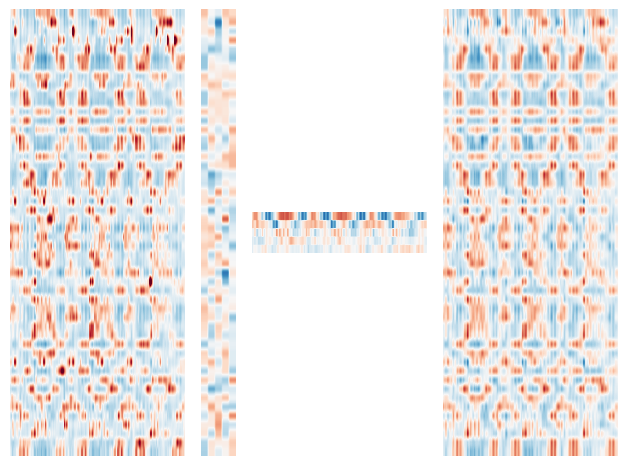

In [22]:
from scipy.stats import zscore
from sklearn.decomposition import PCA

pca=PCA(n_components=10)
principalComponents=pca.fit_transform(zscore(all_traces,1))

f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [5, 1,5,5]})

a0.imshow(all_traces, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r")
a0.axis('off')
A=np.transpose([v[:,0].real,]*3)
B=np.transpose([v[:,1].real,]*3)
C=np.transpose([v[:,2].real,]*3)
D=np.transpose([v[:,3].real,]*3)
E=np.transpose([v[:,4].real,]*3)

a1.imshow(np.concatenate((A,B,C,D,E),axis=1), aspect="auto", vmin=-0.6, vmax=0.6, cmap="RdBu_r");
a1.axis('off');


np.concatenate(([pca.components_[0],]*100,[pca.components_[1],]*100))

a2.imshow(np.concatenate(([Loadings[0],]*100,[Loadings[1],]*100,[Loadings[2],]*100,[Loadings[3],]*100,[Loadings[4],]*100)), vmin=-10, vmax=10, cmap="RdBu_r");
a2.axis('off');

a3.imshow(np.outer(v[:,0].real,Loadings[0])+np.outer(v[:,1].real,Loadings[1])+np.outer(v[:,2].real,Loadings[2])+np.outer(v[:,3].real,Loadings[3])+np.outer(v[:,4].real,Loadings[4]), aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r");

a3.axis('off');
f.tight_layout()

# f.savefig(str(savedir / 'dimred-neur-five-pc.pdf'), dpi=600, format='pdf', bbox_inches='tight');

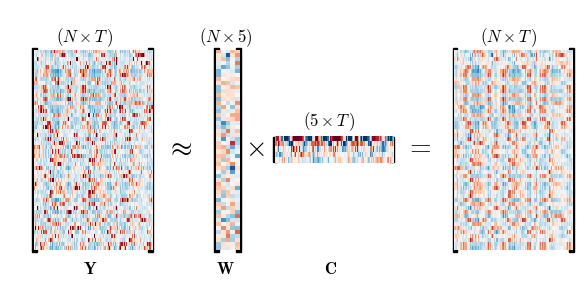

<Figure size 640x480 with 0 Axes>

In [23]:
from scipy.stats import zscore
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle


A=np.transpose([v[:,0].real,]*3)
B=np.transpose([v[:,1].real,]*3)
C=np.transpose([v[:,2].real,]*3)
D=np.transpose([v[:,3].real,]*3)
E=np.transpose([v[:,4].real,]*3)
f, ax = plt.subplots(1, 1, figsize=(6,3))

ax1 = ax.inset_axes([0, 0, 5, 5], transform = ax.transData)
ax.text(5.6,2.38,r'$\approx$',fontsize=20,color='k')
ax2 = ax.inset_axes([7.7, 0, 1, 5], transform = ax.transData)
ax.text(8.95,2.36,r'$\times$',fontsize=20,color='k')
ax3 = ax.inset_axes([10.2, 2, 5, 1], transform = ax.transData)
ax.text(15.7,2.4,r'$=$',fontsize=20,color='k')
ax4 = ax.inset_axes([17.8, 0, 5, 5], transform = ax.transData)

ax.text(2.1,-0.6,r'$\bf{Y}$',fontsize=12,color='k')
ax.text(7.7,-0.6,r'$\bf{W}$',fontsize=12,color='k')
ax.text(12.3,-0.6,r'$\bf{C}$',fontsize=12,color='k')

ax.text((2/3)*1.4,5.2,r'$(N\times T\,)$',fontsize=12,color='k')
ax.text(7,5.2,r'$(N\times 5)$',fontsize=12,color='k')
ax.text(11.4,3.1,r'$(5\times T\,)$',fontsize=12,color='k')
ax.text(18.9,5.2,r'$(N\times T\,)$',fontsize=12,color='k')
 
ax.add_patch(Rectangle((-0.05, -0.04), 0.2, 5.08,color='k'))
ax.add_patch(Rectangle((4.86, -0.04), 0.2, 5.08,color='k'))
ax.add_patch(Rectangle((7.65, -0.04), 0.2, 5.08,color='k'))
ax.add_patch(Rectangle((8.56, -0.04), 0.2, 5.08,color='k'))
ax.add_patch(Rectangle((10.12, 2.19), 0.2, 0.62,color='k'))
ax.add_patch(Rectangle((15.05, 2.19), 0.2, 0.62,color='k'))
ax.add_patch(Rectangle((17.74, -0.04), 0.2, 5.08,color='k'))
ax.add_patch(Rectangle((22.66, -0.04), 0.2, 5.08,color='k'))

ax1.imshow(all_traces, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none")
ax2.imshow(np.concatenate((A,B,C,D,E),axis=1), aspect="auto", vmin=-0.5, vmax=0.5, cmap="RdBu_r", interpolation="none");
ax3.imshow(np.concatenate(([Loadings[0],]*100,[Loadings[1],]*100,[Loadings[2],]*100,[Loadings[3],]*100,[Loadings[4],]*100)), vmin=-5, vmax=5, cmap="RdBu_r", interpolation="none");
ax4.imshow(np.outer(v[:,0].real,Loadings[0])+np.outer(v[:,1].real,Loadings[1])+np.outer(v[:,2].real,Loadings[2])+np.outer(v[:,3].real,Loadings[3])+np.outer(v[:,4].real,Loadings[4]), aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none");

ax1.axis('off')
ax2.axis('off');
ax3.axis('off');
ax4.axis('off');

ax.set_xlim(-1,23)
ax.set_ylim(-0.5,6)
#ax.set_aspect('equal')
ax.axis('off')
f.tight_layout()
fig1=plt.gcf()
plt.show()
plt.draw()

if Save:
    fig1.savefig(str(savedir / 'dimred-neur-five-pc.pdf'), dpi=600, format='pdf', bbox_inches='tight');

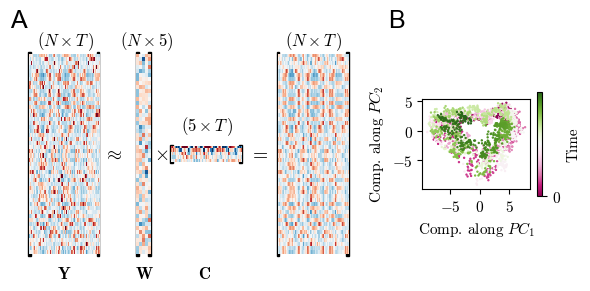

<Figure size 640x480 with 0 Axes>

In [24]:
from scipy.stats import zscore
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle


A=np.transpose([v[:,0].real,]*3)
B=np.transpose([v[:,1].real,]*3)
C=np.transpose([v[:,2].real,]*3)
D=np.transpose([v[:,3].real,]*3)
E=np.transpose([v[:,4].real,]*3)
f, ax = plt.subplots(1, 2, figsize=(6,3), gridspec_kw={'width_ratios': [2, 0.8]})

ax1 = ax[0].inset_axes([0, 0, 5, 5], transform = ax[0].transData)
ax[0].text(5.3,2.38,r'$\approx$',fontsize=14,color='k')
ax2 = ax[0].inset_axes([7.7, 0, 1, 5], transform = ax[0].transData)
ax[0].text(8.95,2.36,r'$\times$',fontsize=14,color='k')
ax3 = ax[0].inset_axes([10.2, 2, 5, 1], transform = ax[0].transData)
ax[0].text(15.7,2.4,r'$=$',fontsize=14,color='k')
ax4 = ax[0].inset_axes([17.8, 0, 5, 5], transform = ax[0].transData)

ax[0].text(2,-0.6,r'$\bf{Y}$',fontsize=12,color='k')
ax[0].text(7.6,-0.6,r'$\bf{W}$',fontsize=12,color='k')
ax[0].text(12.1,-0.6,r'$\bf{C}$',fontsize=12,color='k')

ax[0].text(0.6,5.2,r'$(N\times T\,)$',fontsize=12,color='k')
ax[0].text(6.5,5.2,r'$(N\times 5)$',fontsize=12,color='k')
ax[0].text(10.9,3.1,r'$(5\times T\,)$',fontsize=12,color='k')
ax[0].text(18.3,5.2,r'$(N\times T\,)$',fontsize=12,color='k')
 
ax[0].add_patch(Rectangle((-0.05, -0.04), 0.2, 5.08,color='k'))
ax[0].add_patch(Rectangle((4.86, -0.04), 0.2, 5.08,color='k'))
ax[0].add_patch(Rectangle((7.65, -0.04), 0.2, 5.08,color='k'))
ax[0].add_patch(Rectangle((8.56, -0.04), 0.2, 5.08,color='k'))
ax[0].add_patch(Rectangle((10.12, 2.28), 0.2, 0.45,color='k'))
ax[0].add_patch(Rectangle((15.05, 2.28), 0.2, 0.45,color='k'))
ax[0].add_patch(Rectangle((17.7, -0.04), 0.2, 5.08,color='k'))
ax[0].add_patch(Rectangle((22.66, -0.04), 0.2, 5.08,color='k'))

ax1.imshow(all_traces, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none")
ax2.imshow(np.concatenate((A,B,C,D,E),axis=1), aspect="auto", vmin=-0.5, vmax=0.5, cmap="RdBu_r", interpolation="none");
ax3.imshow(np.concatenate(([Loadings[0],]*100,[Loadings[1],]*100,[Loadings[2],]*100,[Loadings[3],]*100,[Loadings[4],]*100)), vmin=-5, vmax=5, cmap="RdBu_r", interpolation="none");
ax4.imshow(np.outer(v[:,0].real,Loadings[0])+np.outer(v[:,1].real,Loadings[1])+np.outer(v[:,2].real,Loadings[2])+np.outer(v[:,3].real,Loadings[3])+np.outer(v[:,4].real,Loadings[4]), aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none");

ax1.axis('off')
ax2.axis('off');
ax3.axis('off');
ax4.axis('off');

ax[0].set_xlim(-1,23)
ax[0].set_ylim(-0.5,6)

ax[0].axis('off')

im2=ax[1].scatter(Loadings[0,:],Loadings[1,:],s=0.5,c=R,cmap="PiYG")
ax[1].set_xlabel("Comp. along $PC_1$")
ax[1].set_ylabel("Comp. along $PC_2$")
ax[1].set_aspect('equal')
fig.colorbar(im2,ax=ax[1],ticks=range(1),label='Time',shrink=0.4)


f.text(0.02,0.9,'A',fontsize=18,font='Arial')
f.text(0.65,0.9,'B',fontsize=18,font='Arial')

f.tight_layout()
f.add_subplot
fig1=plt.gcf()
plt.show()
plt.draw()

if Save:
    fig1.savefig(str(savedir / 'dimred-neur-five-pc2.pdf'), dpi=600, format='pdf', bbox_inches='tight');

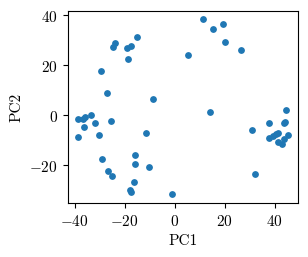

In [25]:
fig, ax=plt.subplots(figsize=(3,2.5))
ax.scatter(principalComponents[:,0],principalComponents[:,1],15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'dimred-neur-2pc-scatter.pdf'), dpi=600, format='pdf', bbox_inches='tight');

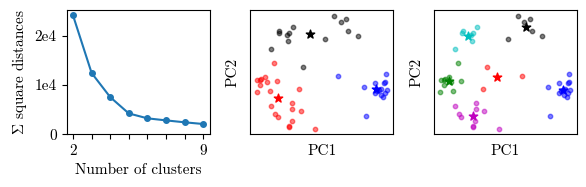

In [26]:
from sklearn.cluster import KMeans

distances=np.zeros((10,1))

for j in range(2,10,1):
    kmeans=KMeans(j,n_init=30).fit(principalComponents[:,0:2])
    Y=kmeans.labels_
    distances[j]=kmeans.inertia_

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,2))

ax1.plot(np.asarray(range(2,10,1)),distances[2:10],marker='o',markersize=4)
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel(r'$\Sigma$ square distances')
ax1.set_xticks([2,3,4,5,6,7,8,9],['2','','','','','','','9'])
ax1.set_yticks([0,10000,20000])
ax1.set_yticklabels(['0','1e4','2e4'])

kmeans=KMeans(3,n_init=30).fit(principalComponents[:,0:2])
Y=kmeans.labels_
Y3=Y
Z3=kmeans.cluster_centers_


for i in range(3):
    X=principalComponents[:,0:2]
    K=X[np.squeeze(Y==i),:]
    if i==0:
        ax2.scatter(K[:,0],K[:,1],10,'r',alpha=0.5)
        ax2.scatter(Z3[i,0],Z3[i,1],40,'r',marker='*')
    if i==1:
        ax2.scatter(K[:,0],K[:,1],10,'b',alpha=0.5)
        ax2.scatter(Z3[i,0],Z3[i,1],40,'b',marker='*')
    if i==2:
        ax2.scatter(K[:,0],K[:,1],10,'k',alpha=0.5)
        ax2.scatter(Z3[i,0],Z3[i,1],40,'k',marker='*')

ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xticks([])
ax2.set_yticks([])

kmeans=KMeans(6,n_init=30).fit(principalComponents[:,0:2])
Y=kmeans.labels_
Z6=kmeans.cluster_centers_
Y6=Y
Z=Z6


for i in range(6):
    X=principalComponents[:,0:2]
    K=X[np.squeeze(Y==i),:]
    if i==0:
        ax3.scatter(K[:,0],K[:,1],10,'r',alpha=0.5)
        ax3.scatter(Z[i,0],Z[i,1],40,'r',marker='*')
    if i==1:
        ax3.scatter(K[:,0],K[:,1],10,'b',alpha=0.5)
        ax3.scatter(Z[i,0],Z[i,1],40,'b',marker='*')
    if i==2:
        ax3.scatter(K[:,0],K[:,1],10,'k',alpha=0.5)
        ax3.scatter(Z[i,0],Z[i,1],40,'k',marker='*')
    if i==3:
        ax3.scatter(K[:,0],K[:,1],10,'g',alpha=0.5)
        ax3.scatter(Z[i,0],Z[i,1],40,'g',marker='*')
    if i==4:
        ax3.scatter(K[:,0],K[:,1],10,'c',alpha=0.5)
        ax3.scatter(Z[i,0],Z[i,1],40,'c',marker='*')
    if i==5:
        ax3.scatter(K[:,0],K[:,1],10,'m',alpha=0.5)
        ax3.scatter(Z[i,0],Z[i,1],40,'m',marker='*')

ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xticks([])
ax3.set_yticks([])

fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'dimred-neur-kmeans.pdf'), dpi=600, format='pdf', bbox_inches='tight');

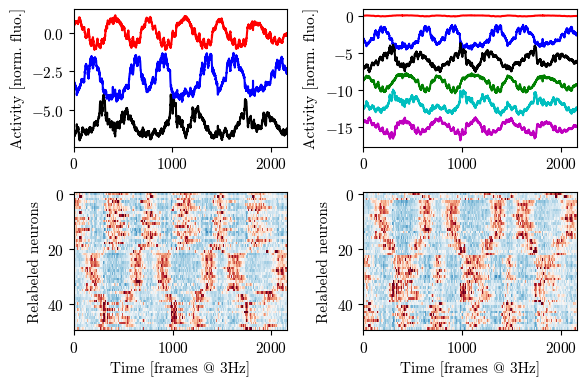

In [27]:
fig,((a0,a1),(a2,a3))=plt.subplots(2,2, figsize=(6,4))
ztraces=zscore(all_traces,1)

a0.plot(Z3[0,0]*pca.components_[0]+Z3[0,1]*pca.components_[1],'r')
a0.plot(Z3[1,0]*pca.components_[0]+Z3[1,1]*pca.components_[1]-3,'b')
a0.plot(Z3[2,0]*pca.components_[0]+Z3[2,1]*pca.components_[1]-6,'k')
a0.set_ylabel('Activity [norm. fluo.]')
a0.set_xlim(0,ztraces.shape[1])

a1.plot(Z6[0,0]*pca.components_[0]+Z6[0,1]*pca.components_[1],'r')
a1.plot(Z6[1,0]*pca.components_[0]+Z6[1,1]*pca.components_[1]-3,'b')
a1.plot(Z6[2,0]*pca.components_[0]+Z6[2,1]*pca.components_[1]-6,'k')
a1.plot(Z6[3,0]*pca.components_[0]+Z6[3,1]*pca.components_[1]-9,'g')
a1.plot(Z6[4,0]*pca.components_[0]+Z6[4,1]*pca.components_[1]-12,'c')
a1.plot(Z6[5,0]*pca.components_[0]+Z6[5,1]*pca.components_[1]-15,'m')
a1.set_ylabel('Activity [norm. fluo.]')
a1.set_xlim(0,ztraces.shape[1])

Zv1=ztraces[Y3==0,:]
Zv1b=np.zeros((1,ztraces.shape[1]))
Zv2=ztraces[Y3==1,:]
Zv3=ztraces[Y3==2,:]

traces_stacked=np.concatenate((Zv1,Zv2,Zv3),axis=0)

a2.imshow(traces_stacked, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none");
a2.set_xlabel('Time [frames @ 3Hz]');
a2.set_ylabel('Relabeled neurons');

Zv1=ztraces[Y6==0,:]
Zv2=ztraces[Y6==1,:]
Zv3=ztraces[Y6==2,:]
Zv4=ztraces[Y6==3,:]
Zv5=ztraces[Y6==4,:]
Zv6=ztraces[Y6==5,:]

traces_stacked=np.concatenate((Zv1,Zv2,Zv3,Zv4,Zv5,Zv6),axis=0)

a3.imshow(traces_stacked, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", interpolation="none");
a3.set_xlabel('Time [frames @ 3Hz]');
a3.set_ylabel('Relabeled neurons');
fig.tight_layout()
fig1=plt.gcf()

if Save:
    fig1.savefig(str(savedir / 'dimred-neur-cluster-traces.pdf'), dpi=600, format='pdf', bbox_inches='tight');

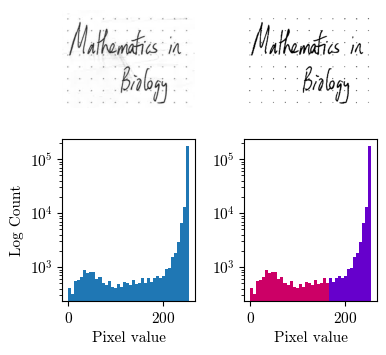

In [28]:
import matplotlib.image as mpimg

im = mpimg.imread(datadir / 'handwritten.png')
im_scaled = im*255
im_scaled = im_scaled.astype('uint8')

fig,((a0,a1),(a2,a3))=plt.subplots(2,2,figsize=(4,4))

a0.imshow(im_scaled, cmap='gray', vmin=0, vmax=255);
a0.axis("off");
X=np.asarray(im_scaled)

n, bins, patches = a2.hist(X.flatten(), 40)

a2.set_yscale('log');
a2.set_xlabel('Pixel value');
v6=a2.set_ylabel('Log Count');
# v5=a2.set_title(r'Histogram of pixel values');

kmeans=KMeans(2,n_init=30).fit(X.reshape(-1,1))
Y=kmeans.labels_
Z6=kmeans.cluster_centers_

Y2=Y.reshape(im.shape[0],im.shape[1]);
if Z6[1,0]>Z6[0,0]:
    X2=X.reshape(-1,1)
    X2[Y==1]=0
    thr=np.max(X2)
    Y2[Y2==1]=255
    Y2[Y2==0]=0

else:
    X2=X.reshape(-1,1)
    X2[Y==0]=0
    thr=np.max(X2)
    Y2[Y2==0]=255
    Y2[Y2==1]=0

a1.imshow(Y2, cmap='gray', vmin=0, vmax=255);
a1.axis("off");

bins2=np.zeros(bins.shape[0]-1)
for i in range(bins.shape[0]-1):
    bins2[i]=(bins[i]+bins[i+1])/2

b4=a3.bar(bins2[bins2<thr],n[bins2<thr],width=bins[1]-bins[0],color=[0.8,0,0.4]);
b5=a3.bar(bins2[bins2>thr],n[bins2>thr],width=bins[1]-bins[0],color=[0.4,0,0.8]);
v4=a3.set_yscale('log');
v3=a3.set_xlabel('Pixel value');
# v2=a3.set_ylabel('Log Counts');
# v1=a3.set_title(r'Histogram of pixel values');

fig.tight_layout();

if Save:
    fig.savefig(str(savedir / 'dimred-otsu-binarize.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Information theory

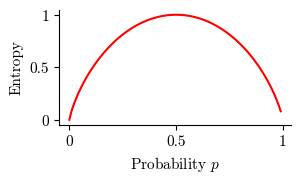

In [29]:
import math

x=np.zeros(100)
H=np.zeros(100)

for i in range(1, 100, 1):
    n=i/100
    x[i]=n
    H[i]=-n*math.log2(n)-(1-n)*math.log2(1-n)

fig, ax=plt.subplots(figsize=(3,1.5))
ax.set_xlabel(u"Probability $p$")
ax.set_ylabel("Entropy")
# ax.set_title("Entropy of a Bernoulli random variable as a function of its parameter")
ax.plot(x,H,'r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0','0.5','1'])
# fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'entropy-bernoulli.pdf'), dpi=600, format='pdf', bbox_inches='tight');

In [30]:
freqs=[8.2, 1.5, 2.8, 4.3, 13, 2.2, 2, 6.1, 7, 0.15, 0.77, 4, 2.4, 6.7, 7.5, 1.9, 0.095, 6, 6.3, 9.1, 2.8, 0.98, 0.24, 0.15, 2, 0.074]

entropy1=0
entropy2=0

for i in range(26):
    entropy1=entropy1-(1/26)*np.log2(1/26)
    entropy2=entropy2-(freqs[i]/100)*np.log2(freqs[i]/100)
print(u"Entropy H\u2080 = "+ str(entropy1))
print(u"Entropy H\u2081 = " + str(entropy2))

Entropy H₀ = 4.70043971814109
Entropy H₁ = 4.075352183088939
